# discrete linear quadratic gaussian control - LQG

- here we presents robust discrete optimal control LQG
- discrete version of LQG can be represented by following block diagram 

- LQG solves problem, ** when no full state x is observed**
- typical aplication is, we can measure position of servo, but no velocitny and current
- this observation is called y
- to reconstruct full state x_hat is used Kalman observer

- reconstructed state x_hat is input into doscrete LQR


![image](../../doc/diagrams/control-lqg_discrete.png)

## servo with inertia

- as controll example we choose DC motor servo with inertia (3rd order system)
- input is applied voltage, u
- state x is (angle, angular rate, motor current)
- observation (measurement) y is only angle

- dynamics described by differential equation, is rewritten into state space model
- continuous system dynamics is converted into discrete using bilinear transformation

### todo - update for 3rd order

![image](../../doc/diagrams/control-servo.png)


In [7]:
import numpy
import scipy
import matplotlib.pyplot as plt


dt = 0.001 

# create dynamical system
# dx = Ax + Bu
# y = Cx
# servo model, 3rd order
# state x = (position, angular velocity, current)
# observation y = (position)

mat_a = numpy.zeros((3, 3))
mat_b = numpy.zeros((3, 1))
mat_b = numpy.zeros((3, 1))
mat_c = numpy.zeros((1, 3))

J = 0.02    #rotor moment of inertia (kg.m^2)
b = 0.2     #drag coefficient (N/m/s)
K = 0.3     #motor constant (N.m.A^-1)
R = 2.0     #wiring resitance, (ohm)
L = 0.4     #wiring inductance, (H)

mat_a[0][1] = 1.0

mat_a[1][1] = -b/J
mat_a[1][2] = K/J

mat_a[2][1] = -K/J
mat_a[2][2] = -R/L

mat_b[2][0] = 1.0/L

mat_c[0][0] = 1.0

# print system dynamics

print("continuous model")
print(mat_a)
print(mat_b)
print(mat_c)
print()

# discretise model using bilinear transform
# x(n+1) = A x(n) + B u(n)
i = numpy.eye(mat_a.shape[0])
 
tmp_a = numpy.linalg.inv(i - (0.5*dt)*mat_a)
tmp_b = i + (0.5*dt)*mat_a

mat_a_disc    = tmp_a@tmp_b
mat_b_disc    = (tmp_a*dt)@mat_b
mat_c_disc    = mat_c

print("discrete model")
print(mat_a_disc)
print(mat_b_disc) 
print(mat_c_disc) 
print()



continuous model
[[  0.   1.   0.]
 [  0. -10.  15.]
 [  0. -15.  -5.]]
[[0. ]
 [0. ]
 [2.5]]
[[1. 0. 0.]]

discrete model
[[ 1.00000000e+00  9.94969326e-04  7.44366079e-06]
 [ 0.00000000e+00  9.89938652e-01  1.48873216e-02]
 [ 0.00000000e+00 -1.48873216e-02  9.94901092e-01]]
[[9.30457599e-09]
 [1.86091520e-05]
 [2.49362637e-03]]
[[1. 0. 0.]]



## controller synthetis

- controll matrices are computed by solving algebraic Riccati equation
- input into solver are system matrices A, B, C, and loss weighting matrices Q and R
- matrix Q (mostly diagonal) penalises state elements deviation from required value
- matrix R (mostly diagonal) penalises control action amplitude


System matrices are expanded - augmented with integral terms, this step is necessary for completly removing steady state error and distrubance rejection.

![image](../../doc/diagrams/control-lqr_discrete_synth.png)


- kalman gain F is sythetised from matrices A, C, and noise covariance
- q_noise matrix : process noise covariance (model uncertainity)
- r_noise matrix : is measurement noise covariance


![image](../../doc/diagrams/control-lqg_discrete_synth.png)


In [8]:
'''
solve the discrete time lqr controller for
x(n+1) = A x(n) + B u(n)
y(n) = C x(n)
cost = sum x[n].T*Q*x[n] + u[n].T*R*u[n]
'''
def solve_discrete_lqr(a, b, c, q, r):

    n = a.shape[0]  #system order
    m = b.shape[1]  #inputs count
    k = c.shape[0]  #outputs count

    #matrix augmentation with integral action
    a_aug = numpy.zeros((n+k, n+k))
    b_aug = numpy.zeros((n+k, m))
    q_aug = numpy.zeros((n+k, n+k))

    
    a_aug[0:n, 0:n] = a 

    #add integrator into augmented a matrix
    for i in range(k):
        a_aug[i + n, i]     = 1.0
        a_aug[i + n, i + n] = 1.0

    b_aug[0:n,0:m]  = b

    #project Q matrix to output, and fill augmented q matrix
    tmp = (c@q).sum(axis=1)
    for i in range(k):
        q_aug[n+i][n+i] = tmp[i]

    # discrete-time algebraic Riccati equation solution
    p = scipy.linalg.solve_discrete_are(a_aug, b_aug, q_aug, r)

    # compute the LQR gain
    ki_tmp =  numpy.linalg.inv(r)@(b_aug.T@p)

    #truncated small elements
    ki_tmp[numpy.abs(ki_tmp) < 10**-10] = 0

    #split ki for k and integral action part ki
    k   = ki_tmp[:, 0:a.shape[0]]
    ki  = ki_tmp[:, a.shape[0]:]

    return k, ki

'''
compute kalman gain matrix for observer : 
x_hat(n+1) = Ax_hat(n) + Bu(n) + K(y(n) - Cx_hat(n))
'''
def solve_kalman_gain(a, c, q, r):
    p = scipy.linalg.solve_discrete_are(a.T, c.T, q, r) 
    k = p@c.T@scipy.linalg.inv(c@p@c.T + r)

    return k

#create loss weighting matrices (diagonal)
q = numpy.array([ [1.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0] ] )
r = numpy.array( [ [20.0] ]) 

#find LQR controll matrices
k, ki = solve_discrete_lqr(mat_a_disc, mat_b_disc, mat_c_disc, q, r)

print("k  = ", k)
print("ki = ", ki)


q_noise = 0.001*numpy.eye(mat_a_disc.shape[0]) 
r_noise = 0.1*numpy.eye(mat_c_disc.shape[0]) 

f = solve_kalman_gain(mat_a_disc, mat_c_disc, q_noise, r_noise)
print("f = ", f)
    

k  =  [[71.57851626  1.91344078  3.19253681]]
ki =  [[0.22449914]]
f =  [[9.51771853e-02]
 [5.49457732e-03]
 [4.00614238e-05]]


## testing controller

- the required state xr is set to (100deg, 0, 0), so the target angle position is 100degrees
- we initalise plant state into zero, and error integrator also as zero
- in for loop we run 1000 steps of simulation


- 1, error between required and observed state is measured
- 2, intergral action is computed
- 3, LQR controll action u is computed
- 4, motor dynamics is simulated


note : here we simulate plant by not accurate Euler method, however, for real systems, the Runge Kutta (RK4) method is much more accurate, especialy for oscilating or unstable dynamical systems

finally, we plot results

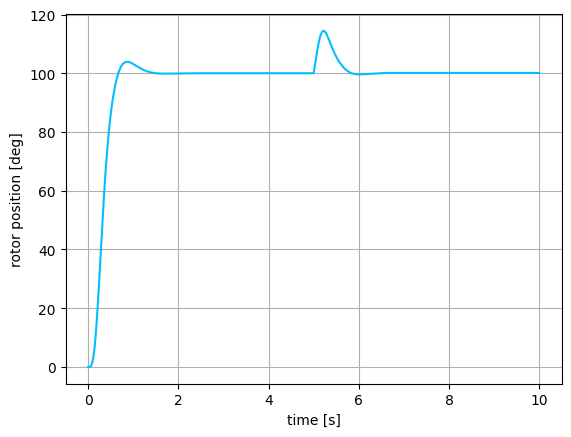

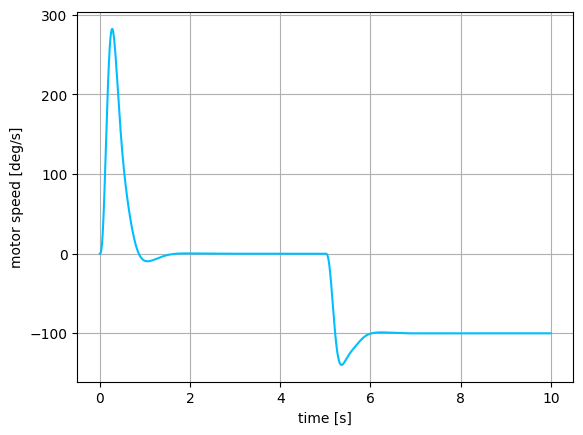

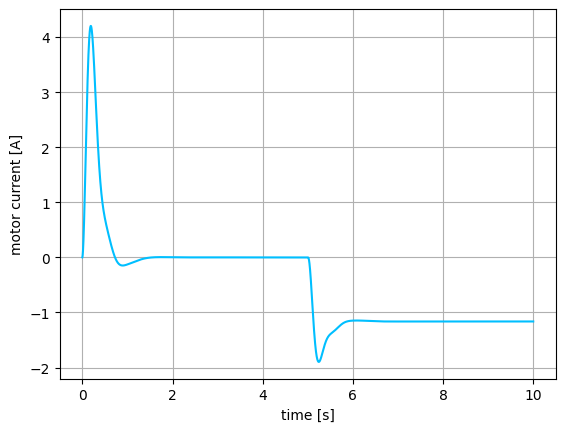

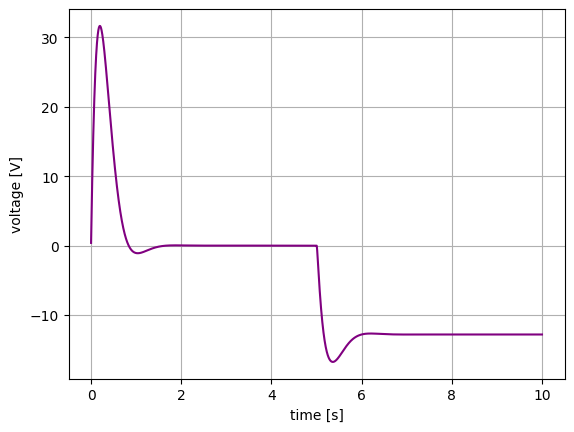

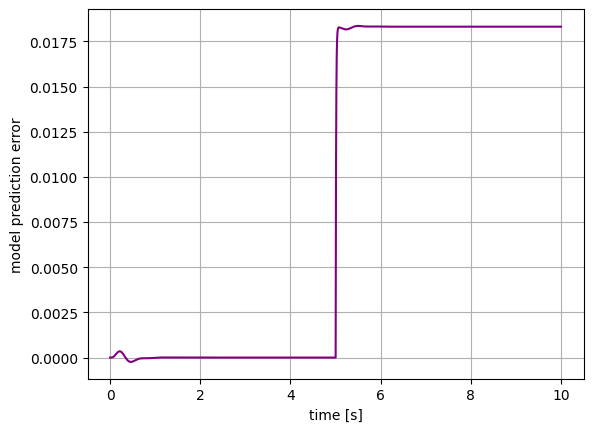

In [9]:
n_max = 10000

#required output, 100degrees
yr = numpy.zeros((mat_c.shape[0], 1))
yr[0][0] = 100.0*numpy.pi/180.0

#initial motor state
x         = numpy.zeros((mat_a.shape[0], 1))
y         = numpy.zeros((mat_c.shape[0], 1))

#kalman estimated state
x_hat = numpy.zeros((mat_a.shape[0], 1))

#we can use random initial state
#x_hat  = numpy.random.randn(mat_a.shape[0], 1)

#initial error integral
integral_action = numpy.zeros((mat_b.shape[1], 1))

u = numpy.zeros((mat_b.shape[1], 1))

#result log
t_result = []
u_result = []
x_result = []
e_result = []

for n in range(n_max):

    # kalman observer
    # only y is known, and using knowledge of dynamics, 
    # the full state x_hat can be reconstructed
    prediction_error = y - mat_c@x_hat
    x_hat = mat_a_disc@x_hat + mat_b_disc@u + f@prediction_error


    #integral action
    error = yr - y
    integral_action+= ki@error

    #LQR controll law
    u = -k@x_hat + integral_action

    #compute plant output
    #primitive euler method for integration
    dx = mat_a@x + mat_b@u
    x+= dx*dt
    y = mat_c@x

    #add constant distrubance in middle
    if n > n_max//2:
        x[0]+= 0.1*numpy.pi/180.0

    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    x_result.append(x[:, 0].copy())
    e_result.append(prediction_error[0, 0])
        

    

u_result = numpy.array(u_result)
x_result = numpy.array(x_result)
e_result = numpy.array(e_result)


# plot results
# angles convert into degrees


plt.clf()
plt.plot(t_result, x_result[:, 0]*180.0/numpy.pi, color="deepskyblue")
plt.xlabel("time [s]")
plt.ylabel("rotor position [deg]")
plt.grid()
plt.show()


plt.clf()
plt.plot(t_result, x_result[:, 1]*180.0/numpy.pi, color="deepskyblue")
plt.xlabel("time [s]")
plt.ylabel("motor speed [deg/s]")
plt.grid()
plt.show()


plt.clf()
plt.plot(t_result, x_result[:, 2], color="deepskyblue")
plt.xlabel("time [s]")
plt.ylabel("motor current [A]")
plt.grid()
plt.show()

plt.clf()
plt.plot(t_result, u_result[:], color="purple")
plt.xlabel("time [s]")
plt.ylabel("voltage [V]")
plt.grid()
plt.show()


plt.clf()
plt.plot(t_result, e_result, color="purple")
plt.xlabel("time [s]")
plt.ylabel("model prediction error")
plt.grid()
plt.show()


## results
- first graph presents servo angle, how it achieve required 100degrees
- on middle time, the distrubance is generated (e.g. external kick or force), and demostrates how controller react for disturbance, and reject it by counteraction

- figures 2, 3 shows rotor speed and coil current
- figure 4 shows control input u

- last figure shows how model deviates from measurement - the disturbance creates non zero error, since kalman observer have no information about external distrubance